In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sns.set()
import warnings
warnings.filterwarnings('ignore')

In [61]:
! gdown 1CETUea909LvQDU4KsfDcU65cxgo5oiA1

Downloading...
From: https://drive.google.com/uc?id=1CETUea909LvQDU4KsfDcU65cxgo5oiA1
To: /content/hinek_data.csv
100% 35.8M/35.8M [00:00<00:00, 214MB/s]


##Предобработка данных

In [62]:
df = pd.read_csv('/content/hinek_data.csv', sep=';')

In [63]:
df.head(2)

,InvoiceNo,ProductID,Name,Quantity,InvoiceDate,PricePerItem,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01.12.10 8:26,3.39,17850.0,United Kingdom


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431673 entries, 0 to 431672
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     431673 non-null  object 
 1   ProductID     431673 non-null  object 
 2   Name          430309 non-null  object 
 3   Quantity      431673 non-null  int64  
 4   InvoiceDate   431673 non-null  object 
 5   PricePerItem  431673 non-null  float64
 6   CustomerID    323570 non-null  float64
 7   Country       431673 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 26.3+ MB


##Формирование датасета

In [65]:
# Удалим строки где нет информации о покупателе
df = df.query("CustomerID == CustomerID")

In [66]:
# Номер дня, месяца и года наблюдения
df['day'] = pd.to_datetime(df.InvoiceDate).dt.day
df['year'] = pd.to_datetime(df.InvoiceDate).dt.year - 2010
df['month'] = df.InvoiceDate.apply(lambda x: int(str(x)[3:5]) - 1)
# Прошло месяцев с начала наблюдений
df['month_past'] = df['year'] * 12 + df['month'] - df.loc[0].month
# Прошло дней с начала наблюдений
df['day_past'] = df['year'] * 365 + df['month'] * 30 + df['day']
df['day_past'] = df['day_past'] - df['day_past'].min()

In [67]:
df.head(2)

,InvoiceNo,ProductID,Name,Quantity,InvoiceDate,PricePerItem,CustomerID,Country,day,year,month,month_past,day_past
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.10 8:26,2.55,17850.0,United Kingdom,12,0,11,0,0
1,536365,71053,WHITE METAL LANTERN,6,01.12.10 8:26,3.39,17850.0,United Kingdom,12,0,11,0,0


In [68]:
# Функция для подготовки датасетов

def data_preparing(df,  period, train=True):
  if train:
    customers = df.query('month_past in @period').CustomerID.unique()
  else:
    customers = df.CustomerID.unique()
  
  total_data = df[df['month_past'] == max(period) + 1]
  df_period = df.copy().query('month_past in @period')
  data = pd.DataFrame(customers, columns=['CustomerID'])

  def count_purch_in_month(df, customer, month_n):
    # Функиция возвращает суммарное количество покупок для каждого покупателя в 
    # Указанный месяц
    return df.query("CustomerID == @customer & month_past == @month_n")['Quantity'].sum()


  # Первая покупка
  def first_purchase(df, customer):
    # Функция возвращает номер дня первой и послежней покупки для указанного покупателя
    cust_df = df[df['CustomerID'] == customer]
    if customer not in df['CustomerID'].unique():
      return [0, 0, 0]
    return [cust_df.iloc[0, 1],
            cust_df.iloc[-1, 1],
            len(cust_df.month_past.unique())]


  def w_p(arr):
    # Функция возвращает количество месяцев покупателя без покупок
    counter = 0
    for elem in arr[1: 11][::-1]:
      if elem > 0:
        return counter
      counter += 1
    # if counter == len(period) - 1:
    #   return 0
    return counter

  # Покупки по месяцам
  for month in period:
    col = f'{month}_m' # Добавить слово покупка
    data[col] = [count_purch_in_month(df_period, customer, month) for customer in customers]
 
  data[['first_purch', 'last_purch', 'm-th_purch']] = [first_purchase(df_period[['CustomerID',
                                                            'day_past',
                                                            'month_past', 'Quantity']], customer) for customer in customers]
                                                      
  
  data['purch_period'] = data['last_purch'] - data['first_purch'] + 1 * (data['last_purch'] - data['first_purch'] != 0)
  data['without_purch'] = data.apply(w_p, axis=1)
  data['sum_purch'] = data.apply(lambda x: sum(x[1: len(period) + 1]), axis=1)
  data['target'] = [(total_data[total_data['CustomerID'] == customer]
                     ['Quantity'].sum() > 0) * 1 for customer in customers]

  return data

In [69]:
last = data_preparing(df, list(range(10)))
to_pred = data_preparing(df, list(range(1, 11)), train=False)

## Тренировка модели

Подготовка тренировочного датасета

In [70]:
# Определение функций для работы с моделями

def plot_importances(cols, weigths, title):
  # Функция визуализирует занчимость признаков для модели

  plt.figure(figsize=(15, 6))
  plt.bar(cols, weigths)  
  plt.xticks(rotation = 45)
  plt.title(title, fontsize=18)
  plt.xlabel('Признак', fontsize=18)
  plt.ylabel('Значимость', fontsize=18)

def display_metrics(model):
  # Функция выводит плозадь под рок кривой, ф1- меру, точность и результаты кроссвалидации модели

  print('Roc auc score:', roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
  print('F1:', f1_score(y_test, model.predict(X_test)))
  print('Accurecy score:', accuracy_score(y_test, model.predict(X_test)))
  print('Cross val score:', np.mean(cross_val_score(model, X_train, y_train, cv=5)))

def MAE(df, model):
  # Функция выводит на экран среднюю абсолютную ошибку модели
  
  df['predicts'] = model.predict_proba(X_test)[:, 1]
  df['errors'] = (df['targets'] - df['predicts']).abs()
  print('Mean absolute error:', round(df['errors'].sum() / len(df), 3))

In [71]:
# Вручную увеличу количество наблюдейний в меньшем классе
datas = last.copy()
datas = datas.append(datas[datas['target'] == 1], ignore_index = True)
datas = datas.append(datas[datas['target'] == 1].sample(n = 646), ignore_index = True)
print("Баланс классов:")
print(datas['target'].value_counts())
targets = datas['target']

Баланс классов:
0    2654
1    2654
Name: target, dtype: int64


In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    datas.drop(['target', 'CustomerID'], axis=1), targets, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
cols = X_train.columns
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
total_data = pd.DataFrame(X_test.copy(), columns=cols)
total_data['targets'] = y_test.values

MMS = MinMaxScaler()
MMS.fit(X_train)
X_train = MMS.transform(X_train)
X_test = MMS.transform(X_test)

Roc auc score: 0.7102183446007674
F1: 0.6018927444794953
Accurecy score: 0.6398401826484018
Cross val score: 0.6580472984718468
Mean absolute error: 0.429


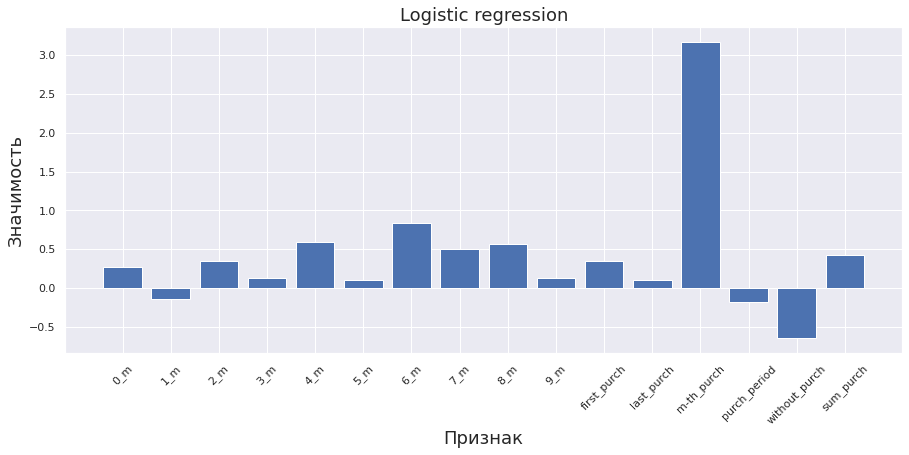

In [73]:
LR = LogisticRegression(solver="liblinear", random_state=2, penalty='l2').fit(X_train, y_train)
plot_importances(cols, LR.coef_[0], 'Logistic regression')
display_metrics(LR)
MAE(total_data.copy(), LR)

Roc auc score: 0.9129401477382475
F1: 0.8467824310520939
Accurecy score: 0.8287671232876712
Cross val score: 0.8028642993726196
Mean absolute error: 0.268


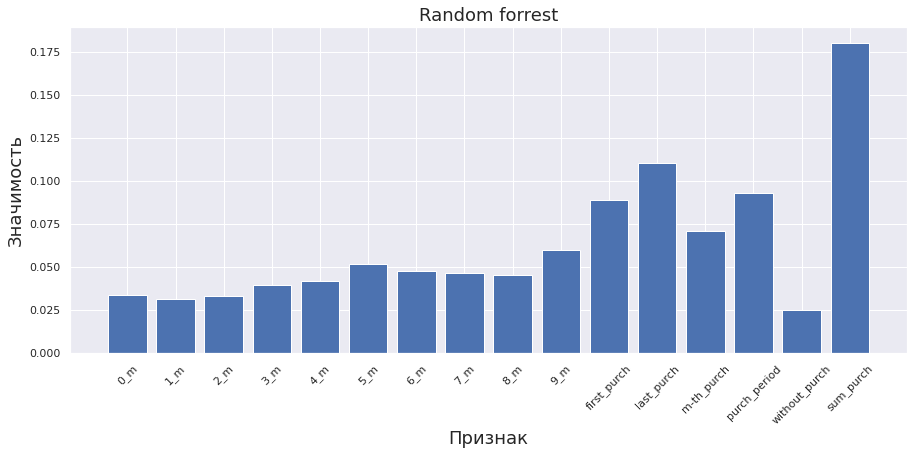

In [74]:
RF = RandomForestClassifier(random_state=0).fit(X_train, y_train)
display_metrics(RF)
plot_importances(cols, RF.feature_importances_, 'Random forrest')
MAE(total_data.copy(), RF)

Roc auc score: 0.756469421315027
F1: 0.6818713450292397
Accurecy score: 0.6894977168949772
Cross val score: 0.6898228480222507
Mean absolute error: 0.407


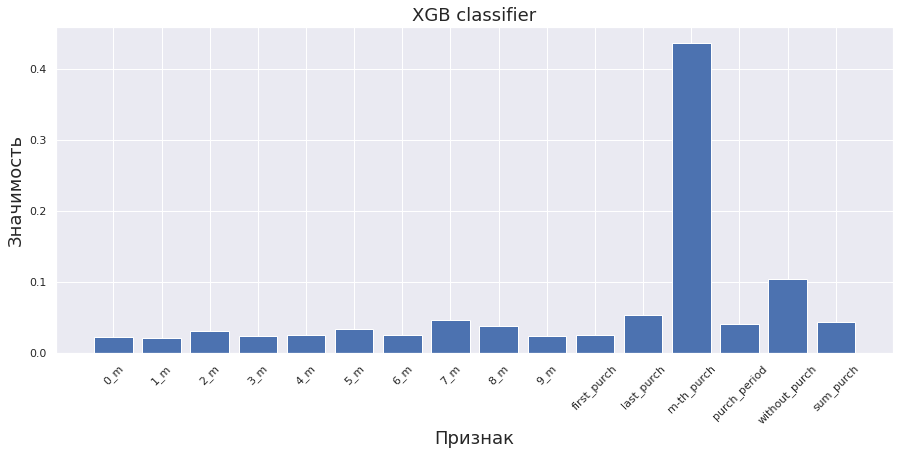

In [75]:
XGB = XGBClassifier(max_depth=3, random_state=2).fit(X_train, y_train)
display_metrics(XGB)
plot_importances(cols, XGB.feature_importances_, 'XGB classifier')
MAE(total_data.copy(), XGB)

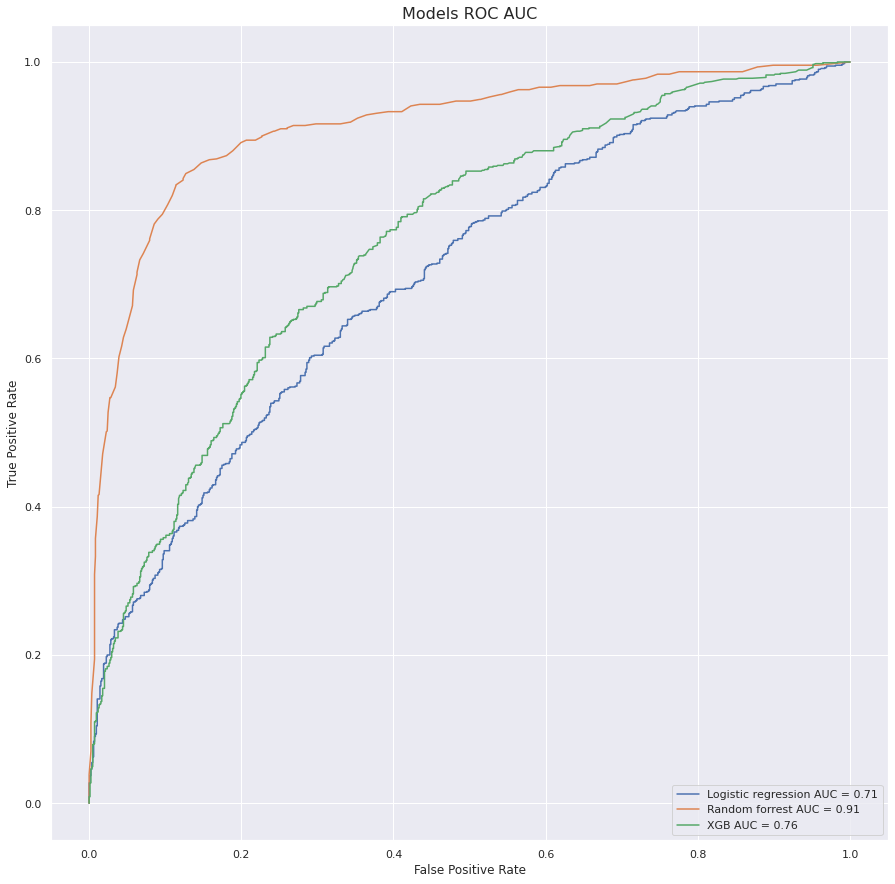

In [76]:
plt.figure(figsize=(15, 15))
y_pred_proba = LR.predict_proba (X_test)[::,1]
fpr, tpr, _ = roc_curve (y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label="Logistic regression AUC = " + str(round(auc, 2)))

y_pred_proba = RF.predict_proba (X_test)[::,1]
fpr, tpr, _ = roc_curve (y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label="Random forrest AUC = " + str(round(auc, 2)))

y_pred_proba = XGB.predict_proba (X_test)[::,1]
fpr, tpr, _ = roc_curve (y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label="XGB AUC = "+ str(round(auc, 2)))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Models ROC AUC', fontsize=16)
plt.legend(loc=4)
plt.show()

Подбор гиперпараметров vмоделей не приводит к увеличению метрик.

Средняя абсолютная ошибка и площадь под рок-аук кривой лучше у случайных деревьев решений.

## Формирование предсказания

Подготовка новых данных для предсказания

In [77]:
customers = to_pred['CustomerID']
total = to_pred.copy().drop(['CustomerID', 'target'], axis=1)

cols = datas.columns
total = scaler.transform(total)
total = MMS.transform(total)

predicts = to_pred.copy()

In [78]:
predicts['RF_prob'] = RF.predict_proba(total)[:, 1].round(2)
predicts['RF_prob'] = predicts.apply(lambda x: x['RF_prob'] / (x['without_purch'] - 1.5) if (x['without_purch'] >= 4) else x['RF_prob'], axis=1)
predicts['RF_predicts'] = RF.predict(total)
predicts['RF_predicts'].value_counts()

0    3088
1     922
Name: RF_predicts, dtype: int64

In [79]:
predicts['LR_prob'] = LR.predict_proba(total)[:, 1]
predicts['LR_predicts'] = LR.predict(total)
predicts['LR_prob'] = predicts.apply(lambda x: x['LR_prob'] / (x['without_purch'] - 1.5) if (x['without_purch'] >= 4) else x['LR_prob'], axis=1)
predicts['LR_predicts'].value_counts()

0    2668
1    1342
Name: LR_predicts, dtype: int64

In [80]:
predicts['XGB_prob'] = XGB.predict_proba(total)[:, 1]
predicts['XGB_predicts'] = XGB.predict(total)
predicts['XGB_prob'] = predicts.apply(lambda x: x['XGB_prob'] / (x['without_purch'] - 1.5) if (x['without_purch'] >= 4) else x['XGB_prob'], axis=1)
predicts['XGB_predicts'].value_counts()

0    2867
1    1143
Name: XGB_predicts, dtype: int64

Баланс классов в предсказаниях не идеальный. Линейная регрессия, явно лучше справилась с задачей классификации.

In [81]:
# Объединю предсказания всех трех моделей, большее значемо буду оценивать пресказания случайного леса
predicts['prob'] = (predicts['RF_prob'] * 2 + predicts['LR_prob'] + predicts['XGB_prob']) / 4

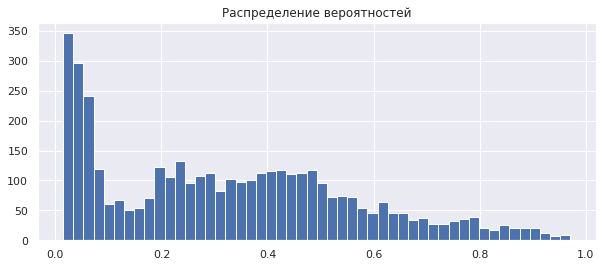

In [82]:
plt.figure(figsize=(10, 4))
predicts['prob'].hist(bins=50);
plt.title('Распределение вероятностей');

In [83]:
predicts['CustomerID'] = predicts['CustomerID'].astype(int)
predicts['prob'] = predicts['prob'].round(7)

In [86]:
predicts[['CustomerID', 'prob']].to_csv('Kuzichev_predicts.csv', index=False, sep=';')